# Evaluating model


## Imports and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Sequence
from functools import partial
from random import randint

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchmetrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# FMD data paths
fmd_X_fp = r'D:\data\face_mask\FMDDetected2\FMD_X_for_model.npy'
fmd_y_fp = r'D:\data\face_mask\FMDDetected2\FMD_y_for_model.npy'

#fmd_X_12k_fp = r'D:\data\face_mask\FaceMaskDetection_12k\Cropped\images.npy'
#fmd_X_12k_fp = r'D:\data\face_mask\FaceMaskDetection_12k\Cropped\labels.npy'



test_dataset_X = fmd_X_fp
test_dataset_y = fmd_y_fp


## Data loader and model

In [3]:
class maskDataset(Dataset):
    def __init__(
        self,
        X_data,
        y_data,
        norm_0_1: bool = True,
        print_stats: bool = True,
    ):        
        self.X_data = X_data
        
        # Norm
        if norm_0_1:
            self.X = self.X_data / 255
        else:
            self.X = self.X_data
        
        self.y = y_data
        
        self.length = len(self.y)
        
        # Print Stats
        if print_stats:
            print('# examples:    {}'.format(self.length))
            ratio = sum(self.y) / self.length
            print('class balence: {:.2f}'.format(ratio))

        # reshape?? see comment in __getitem__() ?????
        self.X = self.X.reshape((self.length, 3, 112, 112)) 
        
    def __len__(self):
        return self.length
    
   
    def __getitem__(self, index):
        image = self.X[index]
        
        # the input to a conv2d must be in [N, C, W, H] format
        #  n = number of examples, c is channels, w is width, and h is height
        #  This means we do not in fact need to transpose the data. it should
        #  be in the shape (3, 112, 112)
        #image = np.transpose(image)
        #image = np.rot90(image, k=3)
        
        return image.astype(np.float32), torch.tensor(self.y[index]).long()    

In [4]:
# function to concat the various data sets and split into train val test

def merge_split(
    X_data_lists: list,
    y_data_lists: list,
    train=0.7,
    val=0.15,
    test=0.15
):
    if (train + val + test) != 1:
        print('splits must add to 1, added to {}'.format(train + val + test))
        return None
    if train < 0 or val < 0 or test < 0:
        print('splits must be positive')
        return None

    # Concat
    X = np.concatenate(X_data_lists)
    y = np.concatenate(y_data_lists)
    
    # split off test
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test, random_state=42)
    
    # split off val
    val_percent_tv = val / (val + train)  # 15 percent of total data is equal to this
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_percent_tv, random_state=42)
    
    return [(X_train, y_train), (X_val, y_val), (X_test, y_test)]

In [5]:
test_X = np.load(test_dataset_X)
test_y = np.load(test_dataset_y)

In [6]:
ds = maskDataset(
    X_data=test_X,
    y_data=test_y,
    norm_0_1=True,
    print_stats=True,
)

# examples:    359
class balence: 0.78


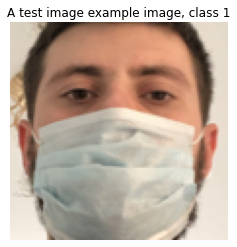

In [7]:
img_idx = randint(0, 359)

image, label = ds[img_idx]

# un-normalize
image = (image * 255).astype(np.uint8)

# show image
plt.imshow(image.reshape(112, 112, 3))
plt.title('A test image example image, class {}'.format(label) )
plt.axis('off')
plt.show()

In [10]:
class CNN(nn.Module):
    def __init__(
        self,
        input_size: Sequence[int] = (3, 112, 112),
        num_classes: int = 2,
        channels: Sequence[int] = (8, 16, 32),
        kernel_sizes: Sequence[int] = (10, 10, 10, 10),
        linear_units: Sequence[int] = (100, 10),
        lr: float = 0.001,
        epochs: int = 10
    ):
        super(CNN, self).__init__()
        
        self.input_size = input_size
        self.num_classes = num_classes
        self.channels = input_size[0:1] + channels
        self.kernel_sizes = kernel_sizes
        self.linear_units = linear_units
        self.lr = lr
        self.epochs = epochs
        
        self.flatten = nn.Flatten()
        self.pool = partial(nn.MaxPool2d, kernel_size=2, stride=2)  # first 2 is for 2x2 kernel, second is stride length
        self.dropout = nn.Dropout
        self.activation = nn.ReLU
        self.accuracy = torchmetrics.functional.accuracy
        self.conf_matrix = torchmetrics.functional.confusion_matrix
        
        # optional, define batch norm here
        
        # build the convolutional layers
        conv_layers = list()
        for in_channels, out_channels, kernel_size in zip(
            self.channels[:-2], self.channels[1:-1], self.kernel_sizes[:-1]
        ):
            conv_layers.append(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    #stride=2,
                    #padding='same',
                )
            )
            conv_layers.append(self.activation())
            conv_layers.append(self.pool())
        # add final layer to convolutions
        conv_layers.append(
            nn.Conv2d(
                in_channels=self.channels[-2],
                out_channels=self.channels[-1],
                kernel_size=self.kernel_sizes[-1],
                stride=2,
                #padding='same',
            )
        )
        conv_layers.append(self.activation())
        conv_layers.append(self.pool())

        
        # turn list into layers
        self.conv_net = nn.Sequential(*conv_layers)
        
        # linear layers
        linear_layers = list()
        prev_linear_size = self.channels[-1] * 9  # const scale it correctly
        for dense_layer_size in self.linear_units:
            linear_layers.append(
                nn.Linear(
                    in_features=prev_linear_size,
                    out_features=dense_layer_size,
                )
            )
            linear_layers.append(self.activation())
            prev_linear_size=dense_layer_size
            
        self.penultimate_dense = nn.Sequential(*linear_layers)
        self.ultimate_dense = nn.Linear(
            in_features=self.linear_units[-1],
            out_features=self.num_classes
        )
    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print(x.shape)
        x = self.conv_net(x)
        x = self.flatten(x)
        # may need to expand dense entry since flatten
        x = self.penultimate_dense(x)
        x = self.ultimate_dense(x)
        return x


def train(dataloader, model, loss_fn, optimizer, verbose=False):
    #model = model.float()  # sometime fixes random obscure type error
    model.train()  # configures for training, grad on, dropout if there is dropout
    size = len(dataloader.dataset)
    
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        
        # compute prediction loss
        preds = model(X)
        loss = loss_fn(preds, y)
        
        # backprop
        loss.backward()
        optimizer.step()
        
        if batch % 5 == 0 and verbose:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

# for evaluating on validation data too
def test(dataloader, model, loss_fn, verbose=False):
    model.eval()
    test_loss, correct = 0, 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    with torch.no_grad():
        for X, y in dataloader:

            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    if verbose:
        print(f"Results: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss
        

In [11]:
test_dataset = maskDataset(
    X_data=test_X,
    y_data=test_y,
    norm_0_1=True,
    print_stats=False,
)

## Load weights into model


### WWMR Only

In [12]:
batch_size = 128

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# chose which model
weights_file_wwrm_only = r'./results/torch_model_weights_WWMR_only'
weights_file_mlfw = r'./results/torch_model_weights_mlfw_only'

weights_file = weights_file_wwrm_only

if weights_file == weights_file_wwrm_only:
    model = CNN(
        linear_units = (100, 50, 10),
    )
    model.load_state_dict(torch.load(weights_file))

else:
    model = CNN()
    model.load_state_dict(torch.load(weights_file))
    

model.eval()  # freezes weights



Using cpu device


CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_net): Sequential(
    (0): Conv2d(3, 8, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(10, 10), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(10, 10), stride=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (penultimate_dense): Sequential(
    (0): Linear(in_features=288, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): ReLU()
  )
  (ultimate_dense): Linear(in_features=10, out_features=2, bias=True)
)

torch.Size([1, 3, 112, 112])
tensor([[ 0.2872, -0.0224]])
predicted class: 0


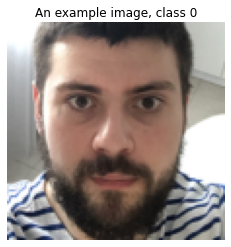

In [13]:
# show an image and show its predicted and true label

idx = 10

img, label = test_dataset[idx]

img_for_model = img.reshape(-1, 3, 112, 112)

model.eval()
with torch.no_grad():
    pred = model(torch.Tensor(img_for_model))

print(pred)
print('predicted class: {}'.format(pred.argmax()))

# un-normalize
image = (img * 255).astype(np.uint8)

# show image
plt.imshow(image.reshape(112, 112, 3))
plt.title('An example image, class {}'.format(label) )
plt.axis('off')
plt.show()

#### WWMR performance on unseen dataset

In [13]:
# get val predictions and true labels for a classification report
preds = []
y_true = []

model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        pred = model(X.float())
        preds.append(pred)
        y_true.append(y)

y_pred = np.concatenate(preds).argmax(1)
y_true = np.concatenate(y_true)

report = classification_report(y_true=y_true, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.22      1.00      0.36        78
           1       0.00      0.00      0.00       281

    accuracy                           0.22       359
   macro avg       0.11      0.50      0.18       359
weighted avg       0.05      0.22      0.08       359



C:\Users\Andrew\anaconda3\envs\DMProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\envs\DMProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\envs\DMProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### mlfw only

In [14]:
batch_size = 128

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# chose which model
weights_file_wwrm_only = r'./results/torch_model_weights_WWMR_only'
weights_file_mlfw = r'./results/torch_model_weights_mlfw_only'

weights_file = weights_file_mlfw

if weights_file == weights_file_wwrm_only:
    model = CNN(
        linear_units = (100, 50, 10),
    )
    model.load_state_dict(torch.load(weights_file))

else:
    model = CNN()
    model.load_state_dict(torch.load(weights_file))
    

model.eval()  # freezes weights



Using cpu device


CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_net): Sequential(
    (0): Conv2d(3, 8, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(10, 10), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(10, 10), stride=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (penultimate_dense): Sequential(
    (0): Linear(in_features=288, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
    (3): ReLU()
  )
  (ultimate_dense): Linear(in_features=10, out_features=2, bias=True)
)

#### mlfw performance on unseen dataset

In [15]:
# WWMR only

# get val predictions and true labels for a classification report
preds = []
y_true = []

model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        pred = model(X.float())
        preds.append(pred)
        y_true.append(y)

y_pred = np.concatenate(preds).argmax(1)
y_true = np.concatenate(y_true)

report = classification_report(y_true=y_true, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.54      0.50      0.52        78
           1       0.86      0.88      0.87       281

    accuracy                           0.80       359
   macro avg       0.70      0.69      0.70       359
weighted avg       0.79      0.80      0.80       359



### Multi Dataset Model

In [16]:
full_model_path = r'C:\Users\Andrew\Documents\2022 Summer\Data Mining\Project\results\upgrade\full_model_best'

model = torch.load(full_model_path)
model.eval()

CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_net): Sequential(
    (0): Conv2d(3, 8, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(10, 10), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 20, kernel_size=(10, 10), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(20, 24, kernel_size=(12, 12), stride=(2, 2))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(24, 24, kernel_size=(12, 12), stride=(2, 2))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (penultimate_dense): Sequential(
    (0): Linear(in_features=864, out_features=1000, bias=True)
    (1): ReLU(

In [17]:
# mlfw only

# get val predictions and true labels for a classification report
preds = []
y_true = []

model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        pred = model(X.float())
        preds.append(pred)
        y_true.append(y)

y_pred = np.concatenate(preds).argmax(1)
y_true = np.concatenate(y_true)

report = classification_report(y_true=y_true, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.57      0.72      0.63        78
           1       0.92      0.85      0.88       281

    accuracy                           0.82       359
   macro avg       0.74      0.78      0.76       359
weighted avg       0.84      0.82      0.83       359



## Results

**F1 scores for each model**
* WWMR dataset trained model only: 0.08
* mlfw dataset trained model only: 0.80
* all dataset trained model only: 0.83

The performance on the model trained on all dataset is the highest when looking at precision, recall, or f1-score. This model is trained on more data, but more importantly, it is trained on data from different datasets in the problem space, so we belive that it is more generalizable. 

In the image domain, each dataset usually shares some characteristics that make is not fully reperazentative of the entire domain. For example, one dataset, the WWMR dataset, is entirely selfies. This dataset does not have many images looking down on someone (i.e. camera higher than head). A model trained on this data alone would be poor at tackling images far from it's training space.